In [4]:
%load_ext autoreload
%autoreload 2

from __future__ import division

import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
# from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)


import types
import uuid
import math
import tensorflow as tf
from scipy.misc import logsumexp
# from baselines import deepq
# import baselines.common.tf_util as U

from utils.min_norm_solvers_numpy import MinNormSolver, gradient_normalizers


from envs.environment_visualization_utils import plot_values, plot_mars, plot_reward_map, plot_texture_map, plot_tile_map
from envs.environment_setup_utils import get_mdp
from utils.tf_utils import save_tf_vars, load_tf_vars, os_setup
from utils.soft_q_learning import tabsoftq_learn_Qs, tabsoftq_gen_pol, generate_demonstrations, vectorize_rollouts
from utils.data_utils import initialize_data_files, load_data
from utils.model_setup import create_tf_model
from utils.learning_utils import generate_constraints, nn_vectorize_rollouts, get_rollout_indexes, sample_batch
from envs.environment_utils import featurize_states
from utils.demos_utils import get_demos


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Environment Setup

In [5]:
os_setup()
data_dir = os.path.join('data', '1.1')
mdp = get_mdp(0)

In [6]:
#visualization demos

#plot_reward_map(mdp)
#plot_texture_map(mdp)
#plot_tile_map(mdp)

# Soft-Q Learning for Demonstrations

Sanity check (env and softq)

In [7]:
#temp_Q = tabsoftq_learn_Qs(mdp, gamma=0.95)
#plot_mars(mdp, tabsoftq_gen_pol(temp_Q*50), Qs=temp_Q)


# Model Set Up

In [8]:
gamma = 0.99
alpha = 1e-4
beta1 = 0.9
beta2 = 0.999999
sq_td_err_penalty = 1
trans_penalty = 1
t_err_penalty = 1e0
q_err_penalty = 1e0
constraint_batch_size = 512

q_n_layers = 2
q_layer_size = 2048
q_activation = tf.nn.tanh
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 256
invdyn_activation = tf.nn.relu
invdyn_output_activation = None


n_act_dim = 5

featurize_acts = lambda a: a
n_dirs = 5

# Boltz-beta determines the "rationality" of the agent being modeled.
# Setting it to higher values corresponds to "pure rationality"
boltz_beta = 50

batch_size=512

In [9]:
###### UNCOMMENT WHEN FIRST RUNNING THIS NOTEBOOK #######
# initialize_data_files(data_dir)
im_scope, q_scope, invsas_scope, invadt_scope = load_data(data_dir)
sess = tf.Session()
compute_batch_loss, idl_train, frank_wolfe_train = create_tf_model(sess, mdp, q_scope, invsas_scope, invadt_scope,
                                               gamma, alpha, beta1, beta2, sq_td_err_penalty, trans_penalty,
                                               t_err_penalty, q_err_penalty, constraint_batch_size,
                                               q_n_layers, q_activation, q_output_activation, invdyn_n_layers,
                                               invdyn_layer_size, invdyn_output_activation, n_act_dim, featurize_acts,
                                               n_dirs, boltz_beta)

# IDL Experiments

## Demo setup

In [10]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False

batch_size = 200
n_demos = 200
demo_time_steps = 40
temp_boltz_beta = 50

In [11]:
constraints, nn_rollouts, train_idxes, val_demo_batch, true_qs, states, adt_samples = get_demos(mdp, gamma, temp_boltz_beta, n_demos, demo_time_steps)

[[208.44793162 207.18127902 207.18127902 208.44793162 210.        ]
 [206.99287621 202.96944566 202.29977102 204.1002877  204.97294744]
 [204.07436214 198.44322909 185.17373676 199.58882701 202.08361852]
 [183.12845022  36.32702745  34.95093068 179.15448334 181.34716572]
 [ 16.97620454  16.79653099  16.97556524  16.98153444  16.8117191 ]
 [ 35.01525282  36.16339701 182.48269324 179.65517111 180.70786631]
 [184.64716479 197.4379815  203.17779759 200.12479717 201.19601961]
 [201.59176201 201.87644087 205.87995687 204.75358624 203.87115731]
 [205.32904157 205.32904157 208.59211573 208.59211573 207.60626319]
 [204.10032334 202.30005617 202.9694813  206.99287621 204.97294744]
 [204.45205845 200.28494297 200.28491827 204.45205492 202.45760476]
 [201.73133557 178.50494151  54.19774545 183.716717   199.76402222]
 [ 18.17234051  18.13088664  17.9742501   18.15392365  17.99061711]
 [  1.63997683   1.63624259   1.63988324   1.63879793   1.62360982]
 [ 17.88075551  18.03661872  18.077807    18.059

[[208.44793162 207.18127902 207.18127902 208.44793162 210.        ]
 [206.99287621 202.96944566 202.29977102 204.1002877  204.97294744]
 [204.07436214 198.44322909 185.17373676 199.58882701 202.08361852]
 [183.12845022  36.32702745  34.95093068 179.15448334 181.34716572]
 [ 16.97620454  16.79653099  16.97556524  16.98153444  16.8117191 ]
 [ 35.01525282  36.16339701 182.48269324 179.65517111 180.70786631]
 [184.64716479 197.4379815  203.17779759 200.12479717 201.19601961]
 [201.59176201 201.87644087 205.87995687 204.75358624 203.87115731]
 [205.32904157 205.32904157 208.59211573 208.59211573 207.60626319]
 [204.10032334 202.30005617 202.9694813  206.99287621 204.97294744]
 [204.45205845 200.28494297 200.28491827 204.45205492 202.45760476]
 [201.73133557 178.50494151  54.19774545 183.716717   199.76402222]
 [ 18.17234051  18.13088664  17.9742501   18.15392365  17.99061711]
 [  1.63997683   1.63624259   1.63988324   1.63879793   1.62360982]
 [ 17.88075551  18.03661872  18.077807    18.059

# # IDL Training

In [12]:
n_training_iters = 1000000

[('loss', 12025983.0)]


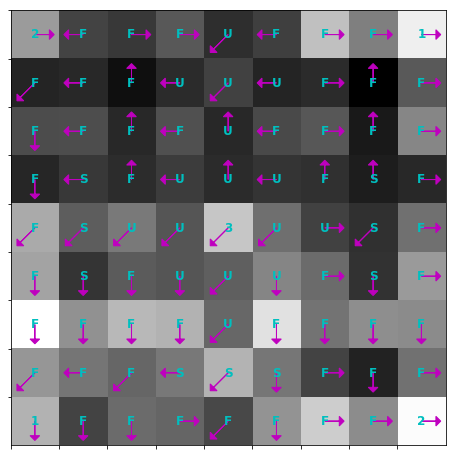

[[0.2        0.2        0.2        0.2        0.2       ]
 [0.19563301 0.20930442 0.20829748 0.18950386 0.19726127]
 [0.19108224 0.21872218 0.21662273 0.17929664 0.19427623]
 [0.18636574 0.22823109 0.22495286 0.16939235 0.19105794]
 [0.18150236 0.23780844 0.23326501 0.15980338 0.18762079]
 [0.18518893 0.1934993  0.20057559 0.20917924 0.21155693]
 [0.176254   0.21525505 0.19023477 0.20560868 0.21264754]
 [0.16830501 0.22938532 0.20083249 0.19050658 0.21097066]
 [0.163087   0.24117608 0.21055967 0.17720503 0.20797223]
 [0.15945183 0.25133753 0.21789175 0.16685964 0.20445922]]


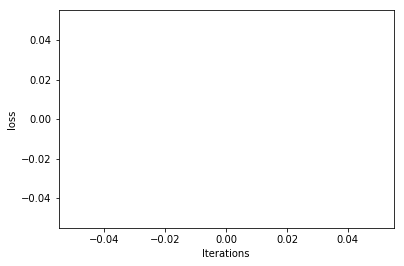

KeyboardInterrupt: 

In [13]:
idl_train(n_training_iters, nn_rollouts, train_idxes, constraints, true_qs, val_demo_batch,
          states, adt_samples, batch_size)

## Frank Wolfe

In [14]:
MAX_ITER = 250
STOP_CRIT = 1e-6
num_tasks = 2

[0.00052655 0.99947345]
[('loss', 6.7362986), ('nall', 0.8594235), ('tde', 4.133501), ('ntll', 1.7433741)]


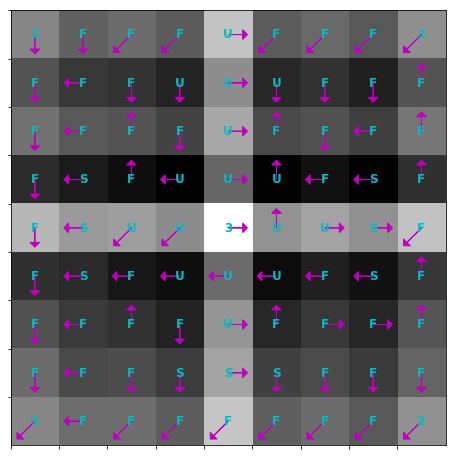

[[0.19999066 0.1999427  0.19991638 0.19992614 0.20022418]
 [0.2133404  0.21421215 0.19486038 0.18526305 0.19232403]
 [0.22689964 0.22875887 0.18930855 0.17110601 0.18392694]
 [0.24048944 0.243452   0.18328142 0.15748648 0.17529063]
 [0.2540196  0.25820088 0.17683806 0.14445423 0.16648728]
 [0.20514719 0.19253786 0.19760108 0.19760402 0.20710988]
 [0.20489286 0.21308942 0.19520062 0.18486077 0.2019563 ]
 [0.21315359 0.23259215 0.19124693 0.17073202 0.19227532]
 [0.22409123 0.24971509 0.1859775  0.15603223 0.18418398]
 [0.23581593 0.26537794 0.18077525 0.14307337 0.17495748]]


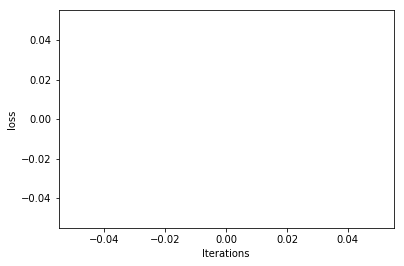

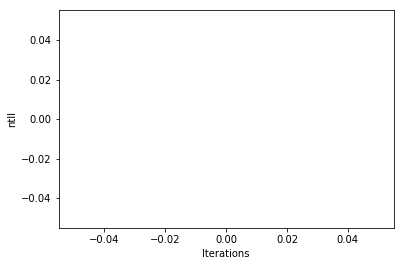

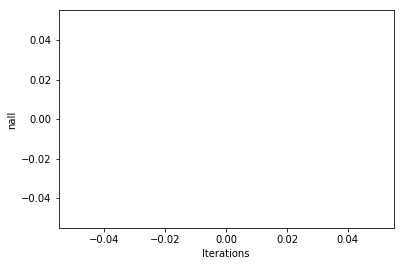

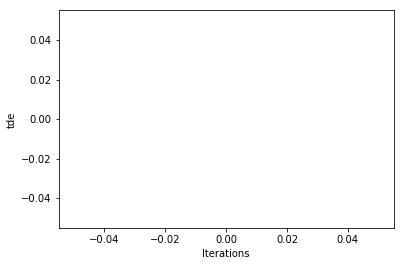

KeyboardInterrupt: 

In [15]:
frank_wolfe_train(sess, n_training_iters, nn_rollouts, train_idxes, batch_size, constraints, num_tasks, val_demo_batch,
                         states, adt_samples, MAX_ITER, STOP_CRIT)

## Testing Training Results

In [16]:
# Sample full dynamics model
adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]

NameError: name 'adt_pred_dir' is not defined

In [17]:
# Print learned dynamics
softmax(adt_probs)

NameError: name 'softmax' is not defined

In [18]:
# Sample full q-fn model
q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
# q_vals = sess.run([demo_q_t], feed_dict={demo_obs_t_feats_ph:states})[0]

NameError: name 'constraint_q_ts' is not defined

In [19]:
# Plot learned q-values and true q-values
plot_values(mdp, q_vals)
plot_values(mdp, Qs)

NameError: name 'q_vals' is not defined

In [20]:
# More comprehensive debugging stuff

test_constraint_adt_pred_probs =  tf.placeholder(tf.float32, [None, n_dirs], name="tpp")
test_constraint_q_t_ph = tf.placeholder(tf.float32, [None], name="tcq")
test_constraint_q_tp1_ph = tf.placeholder(tf.float32, [None, n_dirs, n_act_dim], name="tcqp1")
test_constraint_v_tp1 = tf.reduce_logsumexp(test_constraint_q_tp1_ph, axis=2) #- np.log(5) 
test_adt_V = tf.multiply(test_constraint_v_tp1, test_constraint_adt_pred_probs)
test_adt_target = constraint_rew_t_ph + gamma * tf.reduce_sum(test_adt_V, axis=1)
indiv_errs = test_constraint_q_t_ph - test_adt_target
test_adt_td_err = tf.reduce_mean((test_constraint_q_t_ph - test_adt_target)**2)

NameError: name 'constraint_rew_t_ph' is not defined

In [21]:
# Q-fn Model Storage
q_net_path = os.path.join(data_dir, 'adt_true_q.tf')
save_tf_vars(sess, q_scope, q_net_path)

In [72]:
# Dynamics Model Storage
invadt_path = os.path.join(data_dir, 'adt_fw_t.tf')
save_tf_vars(sess, invadt_scope, invadt_path)

In [73]:
# Training data Storage
pkl.dump(mode_logs, open('adt_fw.pkl', 'wb'))